In [71]:
"""
Car Evaluation Data Set
http://archive.ics.uci.edu/ml/datasets/Car+Evaluation
Data Set:
http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data

Attribute Information:

Class Values:
 
unacc, acc, good, vgood

Attributes:

buying: vhigh, high, med, low.
maint: vhigh, high, med, low.
doors: 2, 3, 4, 5more.
persons: 2, 4, more.
lug_boot: small, med, big.
safety: low, med, high.
"""

import numpy as np
import pandas as pd


carData = pd.read_csv("car.data")

In [72]:
carData.columns = ['buying','maint','doors','persons','lug_boot','safety','class']

In [73]:
# Assign meaningful column names and mapping for the low-high sort of features.

from sklearn.preprocessing import OrdinalEncoder

lowToVHighMapping = {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1}
smallToBigMapping = {'big': 3, 'med': 2, 'small': 1}
acceptabilityMapping = {'vgood': 4, 'good': 3, 'acc': 2, 'unacc': 1}
replace_map = {'buying': lowToVHighMapping, 'maint': lowToVHighMapping, 'doors': {'5more':5}, 'persons': {'more':5}, 'lug_boot': smallToBigMapping, 'safety': lowToVHighMapping, 'class': acceptabilityMapping}
carData = carData.replace(replace_map)
carData['persons'] = carData['persons'].astype('int64')
carData['doors'] = carData['doors'].astype('int64')

In [74]:
carData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
buying      1727 non-null int64
maint       1727 non-null int64
doors       1727 non-null int64
persons     1727 non-null int64
lug_boot    1727 non-null int64
safety      1727 non-null int64
class       1727 non-null int64
dtypes: int64(7)
memory usage: 94.5 KB


In [75]:
corrMatrix = carData.corr()

corrMatrix["class"].sort_values(ascending=False)

class       1.000000
safety      0.439171
persons     0.373253
lug_boot    0.157617
doors       0.065662
maint      -0.232128
buying     -0.282488
Name: class, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f95b7a41c50>,
      dtype=object)

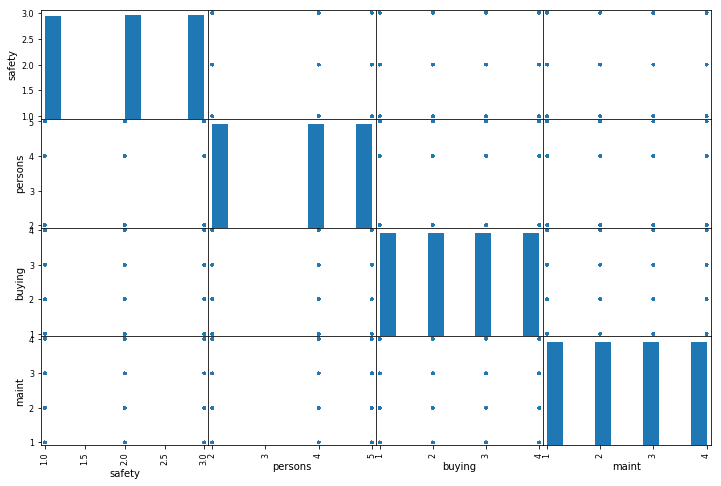

In [76]:
from pandas.plotting import scatter_matrix
attributes = ['safety','persons','buying','maint']
scatter_matrix(carData[attributes], figsize=(12,8))

In [77]:
#Split data into testing and training
from sklearn.model_selection import train_test_split

X = carData.drop('class',axis=1)
y = carData['class'].copy()

trainingData, testingData, trainingLabels, testingLabels = train_test_split(X, y, test_size=0.2, random_state=131)

In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier()
knn.fit(trainingData, trainingLabels)

cross_val_score(knn, trainingData, trainingLabels, cv=10, n_jobs=16, scoring="accuracy")

array([0.94, 0.96, 0.95, 0.98, 0.94, 0.96, 0.96, 0.98, 0.94, 0.98])

In [80]:
from sklearn.model_selection import cross_val_predict

trainingLabelPredictions = cross_val_predict(knn, trainingData, trainingLabels, cv=10, n_jobs=16)

In [81]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(trainingLabels, trainingLabelPredictions)

In [82]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()
def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows
def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

print("label precision recall")
for label in range(4):
    print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

label precision recall
    0     0.980  0.990
    1     0.901  0.925
    2     0.865  0.763
    3     1.000  0.792


In [83]:
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [84]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(15,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [85]:
from sklearn.model_selection import validation_curve

def plot_model_complexity_curve(estimator, X, y, param_name, param_range, cv=None, n_jobs=None):
    # Calculate accuracy on training and test set using range of parameter values
    train_scores, test_scores = validation_curve(estimator, 
                                                 X, 
                                                 y, 
                                                 param_name=param_name, 
                                                 param_range=param_range,
                                                 cv=cv, 
                                                 scoring="accuracy", 
                                                 n_jobs=n_jobs)


    plt.figure(figsize=(15,5))
    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot mean accuracy scores for training and test sets
    plt.plot(param_range, train_mean, label="Training score", color="red")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="green")

    # Plot accurancy bands for training and test sets
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="red", alpha=0.1)
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="green", alpha=0.1)

    # Create plot
    plt.title("Model Complexity")
    plt.xlabel(param_name)
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.legend(loc="best")
    
    print(train_mean)
    print(test_mean)

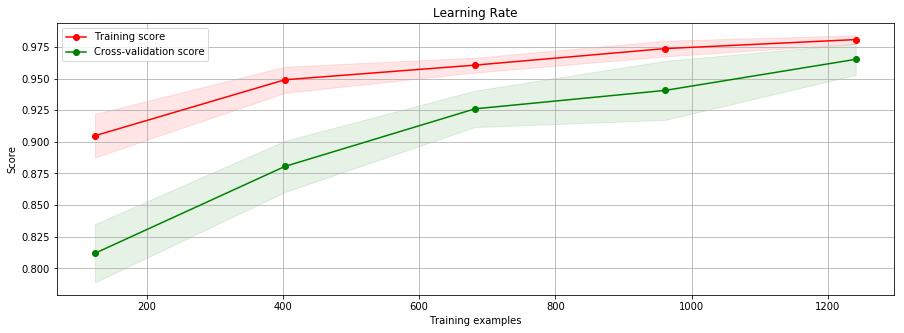

In [86]:
plot_learning_curve(knn,"Learning Rate", trainingData, trainingLabels,n_jobs=-1,cv=10)

plt.show()

[0.94 0.96 0.98 0.97 0.97 0.96 0.96 0.96 0.95 0.95 0.95 0.95 0.95 0.94]
[0.87 0.93 0.95 0.94 0.93 0.93 0.94 0.94 0.94 0.94 0.93 0.93 0.93 0.92]


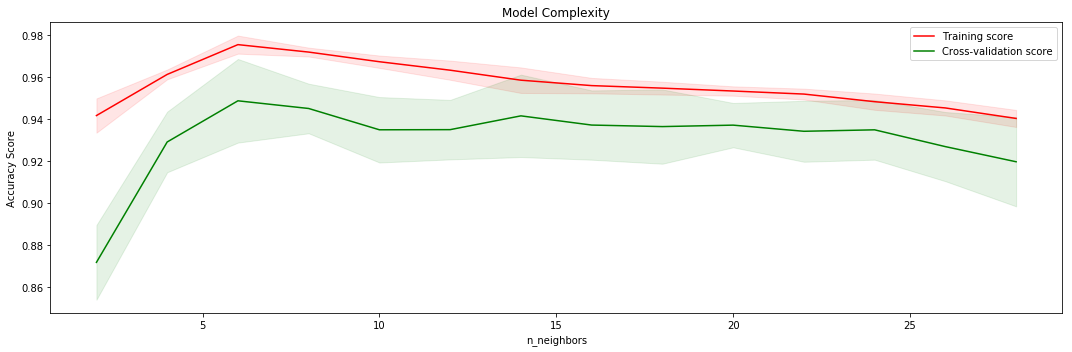

In [87]:

param_range = np.arange(2,30,2)

plot_model_complexity_curve(knn,trainingData, trainingLabels,'n_neighbors',param_range,cv=10,n_jobs=-1)
plt.show()

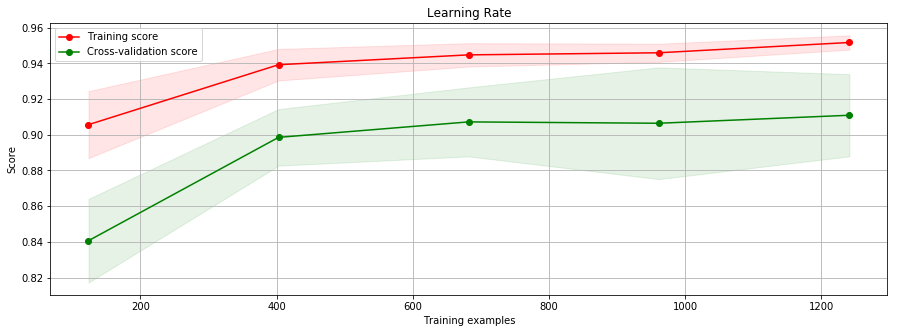

In [88]:
trainingDataNoDoors = trainingData.drop('doors',axis=1)

plot_learning_curve(knn,"Learning Rate", trainingDataNoDoors, trainingLabels,n_jobs=-1,cv=10)

plt.show()

[0.94 0.95 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.95 0.95 0.95 0.95 0.94]
[0.91 0.9  0.9  0.91 0.92 0.92 0.92 0.93 0.94 0.94 0.94 0.94 0.94 0.93]


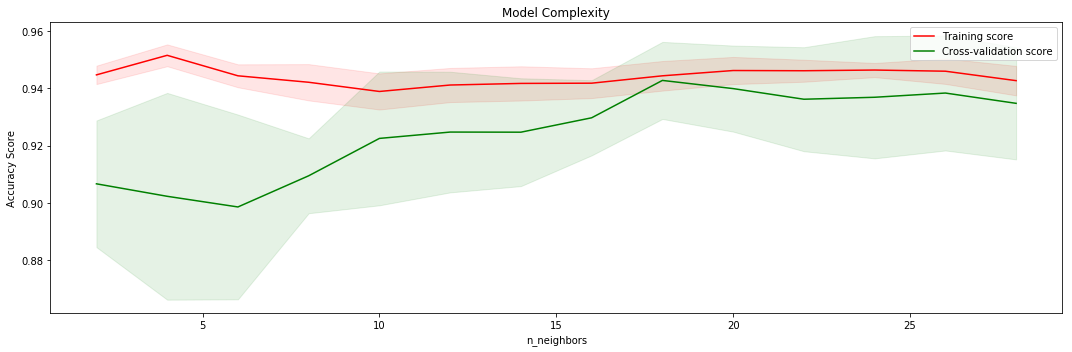

In [89]:
knn.fit(trainingDataNoDoors,trainingLabels)
param_range = np.arange(2,30,2)

plot_model_complexity_curve(knn,trainingDataNoDoors, trainingLabels,'n_neighbors',param_range,cv=10,n_jobs=-1)
plt.show()

[0.94 0.96 0.98 0.97 0.97 0.96 0.96 0.96 0.95 0.95 0.95 0.95 0.95 0.94]
[0.87 0.93 0.95 0.94 0.93 0.93 0.94 0.94 0.94 0.94 0.93 0.93 0.93 0.92]


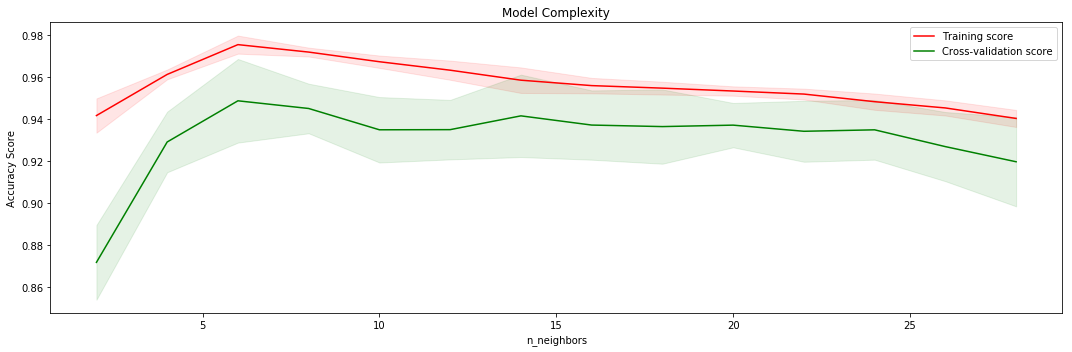

In [90]:
# K-NN Classifier

knn.fit(trainingDataNoDoors,trainingLabels)
param_range = np.arange(2,30,2)

plot_model_complexity_curve(knn,trainingData, trainingLabels,'n_neighbors',param_range,cv=10,n_jobs=-1)
plt.savefig('car_knn_complexity.pdf')
plt.show()

In [91]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(knn, {'n_neighbors': param_range, 'weights': ('distance', 'uniform')}, cv=10, n_jobs=-1)

In [92]:
clf.fit(trainingDataNoDoors, trainingLabels)
print(clf.best_score_)
print(clf.best_estimator_.n_neighbors)
print(clf.best_estimator_.weights)

0.942795076031861
18
uniform


In [93]:
clf.fit(trainingData, trainingLabels)
print(clf.best_score_)
print(clf.best_estimator_.n_neighbors)
print(clf.best_estimator_.weights)

0.9587255611875453
6
distance


In [94]:
## K-NN Prediction Performance
from sklearn.metrics import classification_report

predictions = clf.best_estimator_.predict(testingData)
print(classification_report(testingLabels, predictions))

              precision    recall  f1-score   support

           1       0.97      1.00      0.98       235
           2       0.93      0.92      0.93        89
           3       1.00      0.70      0.82        10
           4       1.00      0.83      0.91        12

    accuracy                           0.96       346
   macro avg       0.98      0.86      0.91       346
weighted avg       0.96      0.96      0.96       346



Normalized confusion matrix


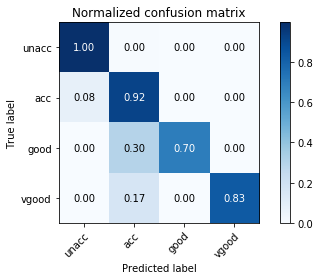

In [95]:
acceptabilityClasses = np.array(('','unacc', 'acc', 'good', 'vgood'))

plot_confusion_matrix(testingLabels.to_numpy(), predictions, normalize=True, classes=acceptabilityClasses)
plt.savefig('car_knn_confusion_matrix.pdf')

plt.show()

[0.71 0.8  0.87 0.94 0.98 1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.  ]
[0.71 0.8  0.86 0.92 0.96 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98]


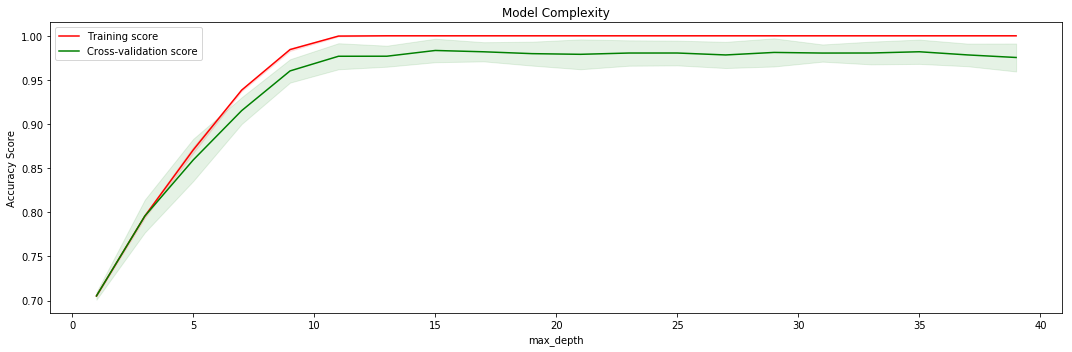

In [96]:
# DecisionTree Classification

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

param_range = np.arange(1,40,2)

plot_model_complexity_curve(dtc,trainingData, trainingLabels,'max_depth',param_range,cv=10,n_jobs=-1)
plt.savefig('car_decisiontree_complexity.pdf')
plt.show()

In [97]:
clf = GridSearchCV(dtc, {'max_depth': param_range },cv=10,n_jobs=-1)
clf.fit(trainingData, trainingLabels)
print(clf.best_score_)
print(clf.best_estimator_.max_depth)

0.9811730629978277
15


In [98]:
## DecisionTree Prediction Performance

predictions = clf.best_estimator_.predict(testingData)
print(classification_report(testingLabels, predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       235
           2       0.97      0.97      0.97        89
           3       0.83      1.00      0.91        10
           4       1.00      0.83      0.91        12

    accuracy                           0.98       346
   macro avg       0.95      0.95      0.95       346
weighted avg       0.98      0.98      0.98       346



Normalized confusion matrix


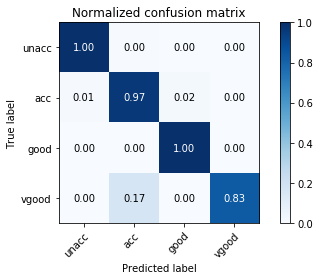

In [99]:
plot_confusion_matrix(testingLabels.to_numpy(), predictions, normalize=True, classes=acceptabilityClasses)
plt.savefig('car_decisiontree_confusion_matrix.pdf')

plt.show()

[0.94 0.96 0.96 0.96 0.96 0.97 0.96 0.96 0.96 0.96 0.97]
[0.93 0.95 0.95 0.95 0.94 0.95 0.95 0.94 0.94 0.95 0.95]


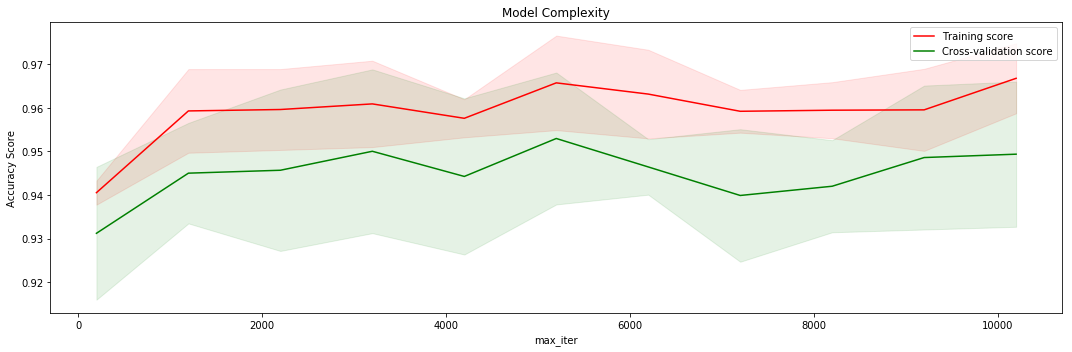

In [100]:
# Neural Network Classification
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
param_range = np.arange(200,10500,1000)
param_name = 'max_iter'

plot_model_complexity_curve(mlp,trainingData, trainingLabels,param_name,param_range,cv=10,n_jobs=-1)
plt.savefig('car_nn_complexity.pdf')
plt.show()

In [101]:
clf = GridSearchCV(mlp, { 'max_iter': param_range },cv=10,n_jobs=-1)
clf.fit(trainingData, trainingLabels)
print(clf.best_score_)
print(clf.best_estimator_.max_iter)

0.9514844315713251
9200


In [102]:
## Neural Network Prediction Performance

predictions = clf.best_estimator_.predict(testingData)
print(classification_report(testingLabels, predictions))

              precision    recall  f1-score   support

           1       0.97      0.97      0.97       235
           2       0.89      0.92      0.91        89
           3       0.89      0.80      0.84        10
           4       1.00      1.00      1.00        12

    accuracy                           0.95       346
   macro avg       0.94      0.92      0.93       346
weighted avg       0.95      0.95      0.95       346



Normalized confusion matrix


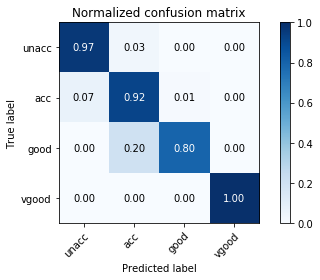

In [103]:
plot_confusion_matrix(testingLabels.to_numpy(), predictions, normalize=True, classes=acceptabilityClasses)
plt.savefig('car_nn_confusion_matrix.pdf')

plt.show()

[0.87 0.7  0.97 0.97]
[0.87 0.7  0.95 0.95]


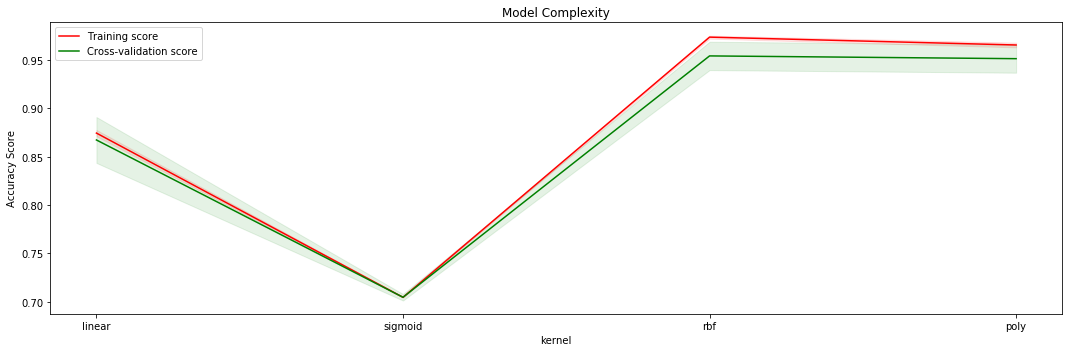

In [104]:
# Support Vector Machine Classification
from sklearn.svm import SVC
svc = SVC(gamma='auto')

param_range = [ 'linear', 'sigmoid', 'rbf', 'poly' ]
param_name = 'kernel'

plot_model_complexity_curve(svc,trainingData, trainingLabels,param_name,param_range,cv=10,n_jobs=-1)
plt.savefig('car_svm_complexity.pdf')
plt.show()

In [105]:
clf = GridSearchCV(svc, {'kernel': param_range},cv=10,n_jobs=-1)
clf.fit(trainingData, trainingLabels)
print(clf.best_score_)
print(clf.best_estimator_.kernel)

0.9543808834178131
rbf


In [106]:
## Support Vector Machine Prediction Performance

predictions = clf.best_estimator_.predict(testingData)
print(classification_report(testingLabels, predictions))

              precision    recall  f1-score   support

           1       0.99      0.97      0.98       235
           2       0.92      0.97      0.95        89
           3       1.00      0.90      0.95        10
           4       1.00      1.00      1.00        12

    accuracy                           0.97       346
   macro avg       0.98      0.96      0.97       346
weighted avg       0.97      0.97      0.97       346



Normalized confusion matrix


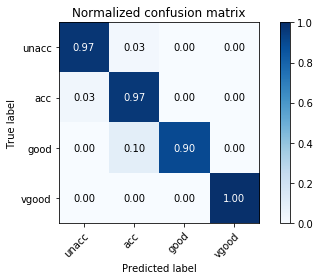

In [107]:
plot_confusion_matrix(testingLabels.to_numpy(), predictions, normalize=True, classes=acceptabilityClasses)
plt.savefig('car_svm_confusion_matrix.pdf')

plt.show()

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98]


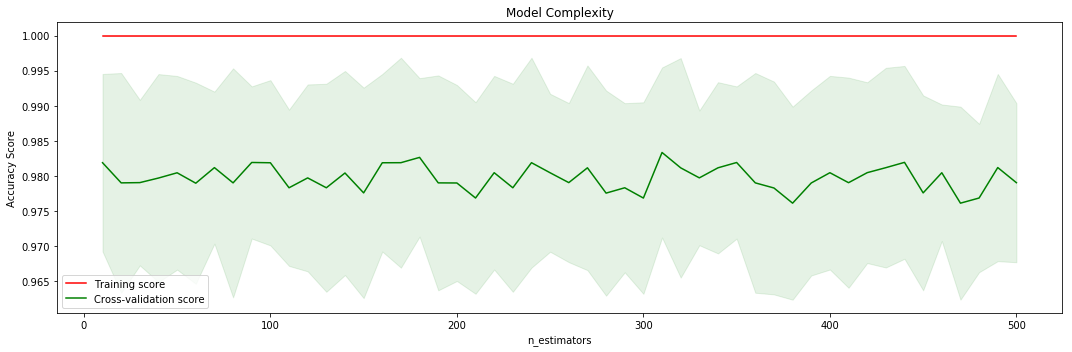

In [108]:
# Boosted Decision Tree Classification
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))

param_range = np.arange(10,510,10)
param_name = 'n_estimators'

plot_model_complexity_curve(abc,trainingData, trainingLabels,param_name,param_range,cv=10,n_jobs=-1)
plt.savefig('car_boosted_complexity.pdf')
plt.show()

In [109]:
clf = GridSearchCV(abc, {'n_estimators': param_range },cv=10,iid=True,n_jobs=-1)
clf.fit(trainingData, trainingLabels)
print(clf.best_score_)
print(clf.best_estimator_.n_estimators)
print(clf.best_estimator_.base_estimator)

0.9840695148443157
360
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [110]:
## Boosted Decision Tree Prediction Performance

predictions = clf.best_estimator_.predict(testingData)
print(classification_report(testingLabels, predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       235
           2       0.99      0.97      0.98        89
           3       0.83      1.00      0.91        10
           4       1.00      1.00      1.00        12

    accuracy                           0.99       346
   macro avg       0.95      0.99      0.97       346
weighted avg       0.99      0.99      0.99       346



Normalized confusion matrix


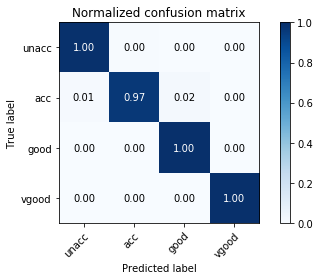

In [111]:
plot_confusion_matrix(testingLabels.to_numpy(), predictions, normalize=True, classes=acceptabilityClasses)
plt.savefig('car_boosted_confusion_matrix.pdf')

plt.show()